<a href="https://colab.research.google.com/github/antoniobelotti/gpu_aco_tsp/blob/master/gpu_aco_tsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Aug 30 15:43:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


#Setup

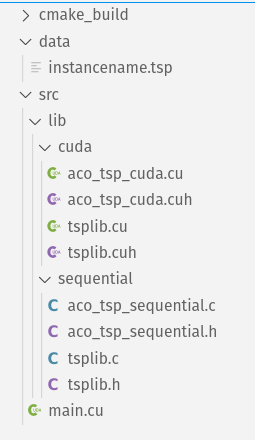

In [ ]:
# Comment this to enable output
%%capture 

# remove default colab stuff
!rm -rf sample_data 

#create directory structure
!mkdir -p src/lib/cuda
!mkdir -p src/lib/sequential

# download TSPLIB intsances
!git clone https://github.com/mastqe/tsplib.git data

# Install nvcc colab plugin
!pip install git+https://github.com/andreinechaev/nvcc4jupyter
%load_ext nvcc_plugin

#Code

##Sequential implementation

###Code to read TSPLIB instances





In [ ]:
%%cuda --name lib/sequential/tsplib.h
#ifndef TSPLIB_H
#define TSPLIB_H

#define ASCII_SLASH 47
#define ASCII_0 48
#define ASCII_9 57

typedef struct node_t{
    int id;
    int x;
    int y;
} Node;

typedef struct TSPInstance_t {
    const int numOfNodes;
    Node *nodes;
    float *edgeCosts;
} TSPInstance;


TSPInstance tsp_instance_read(const char *filename);
void tsp_instance_free(TSPInstance *instance);

#endif //TSPLIB_H

'File written in /content/src/lib/sequential/tsplib.h'

In [ ]:
%%cuda --name lib/sequential/tsplib.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>

#include "tsplib.h"


TSPInstance tsp_instance_read(const char *filename) {
    printf("Reading tsplib instances from %s\n", filename);

    FILE *f = fopen(filename, "r");
    if (f == NULL) {
        printf("Error reading file!");
        exit(1);
    }

    unsigned long filename_len = strlen(filename);
    const char *s = filename + filename_len; // pointer to last char
    for (; *s != ASCII_SLASH; s--); // scan backwards until / is found
    for (; *s < ASCII_0 || *s > ASCII_9; s++); // scan forward until a digit is found

    int num_of_nodes = strtol(s, NULL, 10);

    char line_buff[64];
    Node *nodes = malloc(sizeof *nodes * num_of_nodes);

    while (fgets(line_buff, sizeof line_buff, f) != NULL &&
           strncmp(line_buff, "NODE_COORD_SECTION", strlen("NODE_COORD_SECTION")) != 0);

    while (fgets(line_buff, sizeof line_buff, f) != NULL && strncmp(line_buff, "EOF", 3) != 0) {

        int progr, x, y;

        char *buff_cursor;
        progr = strtol(line_buff, &buff_cursor, 10);
        x = strtol(buff_cursor, &buff_cursor, 10);
        y = strtol(buff_cursor, &buff_cursor, 10);

        // convert to 0-indexed
        progr -= 1;

        nodes[progr].id = progr;
        nodes[progr].x = x;
        nodes[progr].y = y;

    }

    fclose(f);

    TSPInstance instance = {.numOfNodes = num_of_nodes, .nodes = nodes};

    float *edge_cost = malloc(sizeof(int) * num_of_nodes * num_of_nodes);

    float deltaX, deltaY;
    Node n1, n2;
    float weight;
    for (int i = 0; i < num_of_nodes; i++) {
        for (int j = i; j < num_of_nodes; j++) {
            n1 = nodes[i];
            n2 = nodes[j];

            deltaX = (float) (n1.x - n2.x);
            deltaY = (float) (n1.y - n2.y);

            weight = floorf(sqrtf(powf(deltaX, 2) + powf(deltaY,2)));

            edge_cost[n1.id * num_of_nodes + n2.id] = weight;
            edge_cost[n2.id * num_of_nodes + n1.id] = weight;
        }
    }

    instance.edgeCosts = edge_cost;
    return instance;
}

void tsp_instance_free(TSPInstance *instance) {
    free(instance->nodes);
    free(instance->edgeCosts);
}

'File written in /content/src/lib/sequential/tsplib.cu'

In [ ]:
!mv src/lib/sequential/tsplib.cu src/lib/sequential/tsplib.c

###Algorithm

In [ ]:
%%cuda --name lib/sequential/aco_tsp_sequential.h
#ifndef ACO_TSP_SEQUENTIAL_H
#define ACO_TSP_SEQUENTIAL_H

#include "tsplib.h"

void aco_tsp_sequential(
    TSPInstance instance,
    const float ALPHA,
    const float BETA, 
    const float RHO, 
    const float Q, 
    const float PHEROMONE_LB, 
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
);

#endif // ACO_TSP_SEQUENTIAL_H

'File written in /content/src/lib/sequential/aco_tsp_sequential.h'

In [ ]:
# cuda plugin requires .cu extension... change it later to .c
# using %%cuda instead of %%writefile becaus writefile disables syntax highlighting

%%cuda --name lib/sequential/aco_tsp_sequential.cu
#include <stdio.h>
#include <limits.h>
#include <stdbool.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

#include "aco_tsp_sequential.h"

float randf(float right) {
    return ((float) rand() / (float) RAND_MAX) * right;
}

float pheromone_initialization(float *pheromones, const float *edge_cost, int N) {
    /* BUILD greedy path */
    int path[N];
    float path_cost = 0;
    bool visited[N];

    int id_first_node = (int) random() % N;
    visited[id_first_node] = true;

    int current_node = id_first_node;
    for (int i = 1; i < N; i++) {
        int closest_node = -1;
        float closest_node_cost = (float) INT_MAX;

        for (int j = 0; j < N; ++j) {
            if (!visited[j] && current_node != j && edge_cost[current_node * N + j] < closest_node_cost) {
                closest_node_cost = edge_cost[current_node * N + j];
                closest_node = j;
            }
        }

        path[current_node] = closest_node;
        visited[closest_node] = true;
        current_node = closest_node;
        path_cost += closest_node_cost;
    }

    /* set pheromone to N/greedy path cost */
    for (int i = 0; i < N * N; ++i)
        pheromones[i] = (float) N / (float) path_cost;

    
}

void build_paths(int *ant_paths_mx, float *pheromone_trails, float *edge_costs, int N, const float ALPHA, const float BETA) {
    for (int i = 0; i < N * N; i++) ant_paths_mx[i] = -1;

    bool *unvisited_nodes_mx = malloc(sizeof *unvisited_nodes_mx * N * N);
    for (int i = 0; i < N * N; i++) unvisited_nodes_mx[i] = true;

    float *edge_fitness_mx = malloc(sizeof *edge_fitness_mx *N * N);
    for (int r = 0; r < N; ++r)
        for (int c = 0; c < N; ++c)
            edge_fitness_mx[r * N + c] =
                    r == c ? 0 : powf(pheromone_trails[r * N + c], ALPHA) / powf(edge_costs[r * N + c], BETA);

    // build every ant's path
    for (int ant_id = 0; ant_id < N; ++ant_id) {

        // select random starting node
        int id_first_node = (int) random() % N;
        unvisited_nodes_mx[ant_id * N + id_first_node] = false;

        int current_node_id = id_first_node;
        for (int visited_nodes = 1; visited_nodes < N; visited_nodes++) {
            float prefix_sum[N];
            for (int j = 0; j < N; j++) {
                bool mask = unvisited_nodes_mx[ant_id * N + j];
                float fitness = edge_fitness_mx[current_node_id * N + j];
                prefix_sum[j] = (j > 0 ? prefix_sum[j - 1] : 0.0f) + ((float) mask * fitness);
            }

            float random_number = randf(prefix_sum[N - 1]);
            for (int j = 0; j < N; ++j) {
                float ps_prev = j > 0 ? prefix_sum[j - 1] : 0.0f;
                if (random_number >= ps_prev && random_number < prefix_sum[j]) {
                    ant_paths_mx[ant_id * N + current_node_id] = j;
                    unvisited_nodes_mx[ant_id * N + j] = false;
                    current_node_id = j;
                    break;
                }
            }
        }

        ant_paths_mx[ant_id * N + current_node_id] = id_first_node;
    }

    free(edge_fitness_mx);
    free(unvisited_nodes_mx);
}

int update_paths_len(const int *ant_paths_mx, float *ant_paths_len, const float *edge_cost, int N) {
    // keep track of the ant id with the shortest path
    int best_path_ant_id = -1;
    float best_path = (float) INT_MAX;

    for (int ant_id = 0; ant_id < N; ++ant_id) {
        // calculate cost of ant(ant_id) path
        ant_paths_len[ant_id] = 0;
        int current_node = 0;
        int next_node = ant_paths_mx[ant_id * N + current_node];

        for (int i = 0; i < N; ++i) {
            ant_paths_len[ant_id] += edge_cost[current_node * N + next_node];
            current_node = next_node;
            next_node = ant_paths_mx[ant_id * N + current_node];
        }

        if (ant_paths_len[ant_id] < best_path) {
            best_path = ant_paths_len[ant_id];
            best_path_ant_id = ant_id;
        }
    }

    return best_path_ant_id;
}

void pheromone_evaporation(float *pheromones, int N, const float RHO, const float PHEROMONE_LB) {
    for (int i = 0; i < N * N; ++i)
        pheromones[i] = fmaxf((1 - RHO) * pheromones[i], PHEROMONE_LB);
}

void pheromone_update(float *pheromones, const int *paths, const float *paths_len, int N, const float Q, const float PHEROMONE_LB) {
    for (int i = 0; i < N; ++i) {
        for (int j = i; j < N; ++j) {
            float previous_pheromone_value = pheromones[i * N + j];
            float addition = 0.0f;
            for (int ant_id = 0; ant_id < N; ++ant_id)
                // if edge (i,j) is in path of ant ant_id
                if (paths[ant_id * N + i] == j)
                    addition += Q / (float) paths_len[ant_id];


            pheromones[i * N + j] = fmaxf(previous_pheromone_value + addition, PHEROMONE_LB);
        }
    }
}

void aco_tsp_sequential(
    TSPInstance instance,
    const float ALPHA,
    const float BETA, 
    const float RHO, 
    const float Q, 
    const float PHEROMONE_LB, 
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
)
{
    int N = instance.numOfNodes;
    float *pheromone_mx = malloc(sizeof *pheromone_mx * N * N);
    int   *paths_mx = malloc(sizeof *paths_mx *N * N);
    float paths_len[N];
    int best_path[N];
    float best_path_len = (float) INT_MAX;

    pheromone_initialization(pheromone_mx, instance.edgeCosts, N);
    int stagnation_counter = 0;
    for (int iter = 0; iter < MAX_ITERATIONS && stagnation_counter < STAGNATION_THRESHOLD; ++iter, ++stagnation_counter) {
        printf("Generation %d of %d", iter + 1, MAX_ITERATIONS);
        fflush(stdout);
      
        build_paths(paths_mx, pheromone_mx, instance.edgeCosts, N, ALPHA, BETA);
        int current_iteration_best_ant = update_paths_len(paths_mx, paths_len, instance.edgeCosts, N);

        pheromone_evaporation(pheromone_mx, N, RHO, PHEROMONE_LB);
        pheromone_update(pheromone_mx, paths_mx, paths_len, N, Q, PHEROMONE_LB);

        if (paths_len[current_iteration_best_ant] < best_path_len) {
            best_path_len = paths_len[current_iteration_best_ant];

            // save best path
            for (int l = 0; l < instance.numOfNodes; ++l)
                best_path[l] = paths_mx[current_iteration_best_ant * N + l];

            // there's an improvement reset stagnation counter
            stagnation_counter = 0;
        }

        printf("\r");
        fflush(stdout);
    }
    
    free(pheromone_mx);
    free(paths_mx);
    
    char *prefix = stagnation_counter == STAGNATION_THRESHOLD ? "Stopped for stagnation!\n" : "";
    printf("%sBest Path has len: %f\n", prefix, best_path_len);
    for (int j = 0; j < instance.numOfNodes; ++j) printf("%d,", best_path[j] + 1);
    printf("\n");
    fflush(stdout);
}


'File written in /content/src/lib/sequential/aco_tsp_sequential.cu'

In [ ]:
!mv /content/src/lib/sequential/aco_tsp_sequential.cu /content/src/lib/sequential/aco_tsp_sequential.c

##GPU implementation

In [ ]:
%%cuda --name lib/cuda/common.h
#include <sys/time.h>
#include <stdio.h>

#ifndef _COMMON_H
#define _COMMON_H

#define CHECK(call)                                                            \
{                                                                              \
    const cudaError_t error = call;                                            \
    if (error != cudaSuccess)                                                  \
    {                                                                          \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                 \
        fprintf(stderr, "code: %d, reason: %s\n", error,                       \
                cudaGetErrorString(error));                                    \
    }                                                                          \
}

#define CHECK_CURAND(call)                                                     \
{                                                                              \
    curandStatus_t err;                                                        \
    if ((err = (call)) != CURAND_STATUS_SUCCESS)                               \
    {                                                                          \
        fprintf(stderr, "Got CURAND error %d at %s:%d\n", err, __FILE__,       \
                __LINE__);                                                     \
        exit(1);                                                               \
    }                                                                          \
}

#endif // _COMMON_H

'File written in /content/src/lib/cuda/common.h'

### Algorithm

In [ ]:
%%cuda --name lib/cuda/aco_tsp_cuda.h
#ifndef ACO_TSP_CUDA_H
#define ACO_TSP_CUDA_H

#include "../sequential/tsplib.h"
#include "./common.h"

#define DIV_ROUNDUP(NUM,DEN) ((NUM +(DEN-1))/DEN)

void aco_tsp_cuda(
    TSPInstance instance, 
    const float ALPHA,
    const float BETA, 
    const float RHO, 
    const float Q, 
    const float PHEROMONE_LB, 
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
);

#endif // ACO_TSP_CUDA_H

'File written in /content/src/lib/cuda/aco_tsp_cuda.h'

In [ ]:
%%cuda --name lib/cuda/aco_tsp_cuda.cu
#include <stdio.h>
#include <iostream>
#include <assert.h>

#include "aco_tsp_cuda.h"

__global__ void pheromone_reset(float *pheromone_mx, const int N, const float PHEROMONE_LB){
    const int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < N*N)
      pheromone_mx[idx] = PHEROMONE_LB;
}

__global__ void custom_blelloch_prefix_sum(float *data, bool *mask, int n) {
  /*
  Blelloch's prefix scan implementation modified to be inclusive instead of exclusive.
  Each block requires n+1 floats of shared memory

  from gpu gems 3
  */

  extern __shared__ float temp[];
  
  int thid = threadIdx.x;
  int gtid = blockIdx.x*blockDim.x + threadIdx.x;
  int offset = 1;
    
  // load input into shared memory 
  temp[2*thid] = data[2*gtid] * mask[2*gtid]; 
  temp[2*thid+1] = data[2*gtid+1] * mask[2*gtid+1];

  // build sum in place up the tree
  for (int d = n>>1; d > 0; d >>= 1) {
    __syncthreads();

    if (thid < d) { 
      int ai = offset*(2*thid+1)-1;     
      int bi = offset*(2*thid+2)-1;  
      temp[bi] += temp[ai];    
    }
    offset *= 2; 
  }

  if (thid == 0) { 
      temp[n] = temp[n-1]; 
      temp[n-1] = 0.0f;
  }

  // traverse down tree & build scan 
  for (int d = 1; d < n; d *= 2) {      
    offset >>= 1;
    __syncthreads();
    if (thid < d) {
      int ai = offset*(2*thid+1)-1;
      int bi = offset*(2*thid+2)-1;
      float t = temp[ai]; temp[ai] = temp[bi]; temp[bi] += t;
    }
  }
  
  __syncthreads();

  data[2*gtid] = temp[2*thid+1];
  data[2*gtid+1] = temp[2*thid+2];
} 

        
__global__ void population_reset(int *paths_mx, int N){
    const int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < N*N)
      paths_mx[idx] = -1;
}

__global__ void unvisited_node_reset(bool *unvisited_node_mx, int N){
    const int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < N*N)
      unvisited_node_mx[idx] = true;
}

__global__ void build_paths(int *paths_mx, float *pheromone_mx, float *edge_costs, bool *unvisited_nodes_mx, int N, float ALPHA, float BETA){}


__global__ void edge_fitness_update(float *edge_fitness_mx, float *pheromone_mx, float *edge_costs_mx, const int N, const float ALPHA, const float BETA){
    const int row_idx = blockIdx.x;
    const int col_idx = threadIdx.x;
    const int idx = row_idx * blockDim.x + col_idx;

    // TODO: branching trick possible??
    //if (row_idx == col_idx){
    //    edge_fitness_mx[idx] = 0;
    //}else if (idx < N*N){
    //    edge_fitness_mx[idx] = powf(pheromone_mx[idx], ALPHA) / powf(edge_costs_mx[idx], BETA);
    //}
    if (idx < N*N && row_idx != col_idx)
      edge_fitness_mx[idx] = powf(pheromone_mx[idx], ALPHA) / powf(edge_costs_mx[idx], BETA);
}

int closest_multiple_of(int numToRound, int multiple){
  assert(numToRound >0);

  if (multiple == 0)
    return numToRound;

  int remainder = numToRound % multiple;
  if (remainder == 0)
    return numToRound;

  return numToRound + multiple - remainder;
}

void aco_tsp_cuda(
    TSPInstance instance,
    const float ALPHA,
    const float BETA, 
    const float RHO, 
    const float Q, 
    const float PHEROMONE_LB, 
    const int MAX_ITERATIONS,
    const int STAGNATION_THRESHOLD
) 
{
    /* HOST */
    const int N = instance.numOfNodes;

    const int BLOCKSIZE = 256; 

    /* number used to pad array to nearest BLOCKSIZE multiple. This is needed
        for some operations like prefix sum. */
    int block_multiple_N = closest_multiple_of(N, BLOCKSIZE);
 
    /*
    float paths_len[N];
    int best_path[N];
    float best_path_len = (float) INT_MAX;
    */

    /* DEVICE */
    float *pheromone_mx;
    int *paths_mx;
    bool *unvisited_nodes_mx;
    float *edge_costs_mx;
    float *edge_fitness_mx;

    CHECK(cudaMalloc((void **)&pheromone_mx, sizeof(float)*N*N));
    CHECK(cudaMalloc((void **)&paths_mx, sizeof(int)*N*N));
    CHECK(cudaMalloc((void **)&edge_costs_mx, sizeof(float)*N*N));
    CHECK(cudaMalloc((void **)&edge_fitness_mx, sizeof(float)*N*N));
    CHECK(cudaMalloc((void **)&unvisited_nodes_mx, sizeof(bool)*N*N));
 
    CHECK(cudaMemcpy(edge_costs_mx, instance.edgeCosts, sizeof(float)*N*N, cudaMemcpyHostToDevice));
    
    pheromone_reset<<<DIV_ROUNDUP(N,BLOCKSIZE),BLOCKSIZE>>>(pheromone_mx, N, PHEROMONE_LB);
 
    cudaStream_t streams[3];
    cudaStreamCreate(&streams[0]);
    cudaStreamCreate(&streams[1]);
    cudaStreamCreate(&streams[2]);
    
    cudaEvent_t events[3];
    cudaEventCreate(&events[0]);
    cudaEventCreate(&events[1]);
    cudaEventCreate(&events[2]);

    int stagnation_counter = 0;
    for (int iter = 0; iter < MAX_ITERATIONS && stagnation_counter < STAGNATION_THRESHOLD; ++iter, ++stagnation_counter) {
        printf("Generation %d of %d", iter + 1, MAX_ITERATIONS);
        fflush(stdout);

        
        population_reset<<<DIV_ROUNDUP(N,BLOCKSIZE),BLOCKSIZE,0,streams[0]>>>(paths_mx, N);
        cudaEventRecord(events[0], streams[0]);
        unvisited_node_reset<<<DIV_ROUNDUP(N,BLOCKSIZE),BLOCKSIZE,0,streams[1]>>>(unvisited_nodes_mx, N);
        cudaEventRecord(events[1], streams[1]);
        edge_fitness_update<<<DIV_ROUNDUP(N,BLOCKSIZE),BLOCKSIZE,0,streams[2]>>>(edge_fitness_mx, pheromone_mx, edge_costs_mx, N, ALPHA, BETA);
        cudaEventRecord(events[2], streams[2]);

        // for i=0 to N i.e. each node of the path
        //prefix_sum<<<N, N, N*sizeof(int)>>>(edge_fitness_mx, unvisited_nodes);
        
        cudaEventSynchronize(events[0]);
        cudaEventSynchronize(events[1]);
        cudaEventSynchronize(events[2]);


        break;

        //build_paths<<<>>>(paths_mx, pheromone_mx, instance.edgeCosts, unvisited_nodes_mx, N, ALPHA, BETA);
    }    

    /*
    printf("%sBest Path has len: %f\n", stagnation_counter == STAGNATION_THRESHOLD ? "Stopped for stagnation!" :"", best_path_len);
    for (int j = 0; j < instance.numOfNodes; ++j) printf("%d,", best_path[j] + 1);
    printf("\n");
    fflush(stdout);
    */


    cudaStreamDestroy(streams[0]);
    cudaStreamDestroy(streams[1]);
    cudaStreamDestroy(streams[2]);

    cudaEventDestroy(events[0]);
    cudaEventDestroy(events[1]);
    cudaEventDestroy(events[2]);
 
    CHECK(cudaDeviceSynchronize());
    
    cudaFree(pheromone_mx);
    cudaFree(paths_mx);
    cudaFree(unvisited_nodes_mx);
    cudaFree(edge_costs_mx);
    cudaFree(edge_fitness_mx);
     
    CHECK(cudaDeviceReset());
}

'File written in /content/src/lib/cuda/aco_tsp_cuda.cu'

## Glue

In [ ]:
%%writefile src/CMakeLists.txt
cmake_minimum_required(VERSION 3.21)
project(ACO_TSP LANGUAGES CUDA C)

#######################
###   SEQUENTIAL
add_library(
  aco_tsp_sequential STATIC 
  
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/tsplib.h
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/tsplib.c 
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/aco_tsp_sequential.h 
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/sequential/aco_tsp_sequential.c 
)

target_include_directories(aco_tsp_sequential PUBLIC ${CMAKE_CURRENT_SOURCE_DIR})

#######################
###   CUDA

set(CUDA_SEPARABLE_COMPILATION ON)

add_library(
  aco_tsp_cuda STATIC 

  ${CMAKE_CURRENT_SOURCE_DIR}/lib/cuda/aco_tsp_cuda.h
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/cuda/aco_tsp_cuda.cu 
  
  ${CMAKE_CURRENT_SOURCE_DIR}/lib/cuda/common.h
)
target_include_directories (aco_tsp_cuda PUBLIC ${CMAKE_CURRENT_SOURCE_DIR})
set_target_properties(aco_tsp_cuda PROPERTIES CUDA_SEPARABLE_COMPILATION ON)


########### MAIN ###########
add_executable(ACO_TSP main.cu)

target_compile_options(ACO_TSP PRIVATE $<$<COMPILE_LANGUAGE:CUDA>:
                       --generate-line-info
                       --use_fast_math
                       --relocatable-device-code=true
                       -arch=sm_37
                       >)

target_link_libraries(${PROJECT_NAME} PUBLIC m)
target_link_libraries(${PROJECT_NAME} PUBLIC aco_tsp_cuda)
target_link_libraries(${PROJECT_NAME} PUBLIC aco_tsp_sequential)

Overwriting src/CMakeLists.txt


In [ ]:
%%cuda --name main.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

extern "C" { 
  #include "./lib/sequential/tsplib.h"
  #include "./lib/sequential/aco_tsp_sequential.h"
}
#include "./lib/cuda/aco_tsp_cuda.h"


#define RUN_CPU false
#define RUN_GPU true

#define BASE_DATA_FOLDER "/content/data/"

/*
ALPHA importance of pheromone trail
BETA  importance of heuristic visibility
RHO   pheromone evaporation rate
Q     numerator of pheromone update
*/
static const float ALPHA = 1.0f;
static const float BETA = 3.0f;
static const float RHO = 0.8f;
static const float Q = 1.0f;
static const float PHEROMONE_LB = 0.01f;
static const int MAX_ITERATIONS = 100000;
static const int STAGNATION_THRESHOLD = MAX_ITERATIONS/5;

int main(int argc, char **argv) {
    if (argc<2){
      printf("Specify filname\n");
      return -1;
    }

    char filenameBuffer[128];
    strcpy(filenameBuffer, BASE_DATA_FOLDER);
    strcat(filenameBuffer, argv[1]);
    
    TSPInstance instance = tsp_instance_read(filenameBuffer);

  
    if(RUN_CPU){
      srand(time(NULL));
      
      clock_t starts = clock(), diffs;
      
      aco_tsp_sequential(instance, ALPHA, BETA, RHO, Q, PHEROMONE_LB, MAX_ITERATIONS, STAGNATION_THRESHOLD);
      
      diffs = clock() - starts;
      int msecs = diffs * 1000 / CLOCKS_PER_SEC;
      printf("\nSequential took %d seconds %d milliseconds\n", msecs/1000, msecs%1000);
    }


    if(RUN_GPU){
      cudaSetDevice(1);

      clock_t startc = clock(), diffc;

      aco_tsp_cuda(instance, ALPHA, BETA, RHO, Q, PHEROMONE_LB, 1, STAGNATION_THRESHOLD);

      cudaDeviceSynchronize();
      diffc = clock() - startc;
      int msecc = diffc * 1000 / CLOCKS_PER_SEC;
      printf("\nCuda took %d seconds %d milliseconds\n", msecc/1000, msecc%1000);

    }

    tsp_instance_free(&instance);
    return 0;
}

'File written in /content/src/main.cu'

In [ ]:
!mkdir -p cmake_build
%cd cmake_build

!cmake ../src
!cmake --build .
%cd /content

/content/cmake_build
-- Configuring done
-- Generating done
-- Build files have been written to: /content/cmake_build
Consolidate compiler generated dependencies of target aco_tsp_sequential
[ 37%] Built target aco_tsp_sequential
Consolidate compiler generated dependencies of target aco_tsp_cuda
[ 62%] Built target aco_tsp_cuda
Consolidate compiler generated dependencies of target ACO_TSP
[ 75%] Building CUDA object CMakeFiles/ACO_TSP.dir/main.cu.o
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
[ 87%] Linking CUDA device code CMakeFiles/ACO_TSP.dir/cmake_device_link.o
[100%] Linking CUDA executable ACO_TSP
[100%] Built target ACO_TSP
/content


In [ ]:
!./cmake_build/ACO_TSP brd14051.tsp

Reading tsplib instances from /content/data/brd14051.tsp
Generation 1 of 1
Cuda took 0 seconds 637 milliseconds


#DEV

##Prefix Sum

In [ ]:
%%cuda --name gems.cu 

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <assert.h>

#define DIV_ROUNDUP(NUM,DEN) ((NUM +(DEN-1))/DEN)

#define CHECK(call)                                                            \
{                                                                              \
    const cudaError_t error = call;                                            \
    if (error != cudaSuccess)                                                  \
    {                                                                          \
        fprintf(stderr, "Error: %s:%d, ", __FILE__, __LINE__);                 \
        fprintf(stderr, "code: %d, reason: %s\n", error,                       \
                cudaGetErrorString(error));                                    \
    }                                                                          \
}

inline double seconds() {
    struct timeval tp;
    struct timezone tzp;
    int i = gettimeofday(&tp, &tzp);
    return ((double)tp.tv_sec + (double)tp.tv_usec * 1.e-6);
}


__global__ void prescan(float *g_odata, float *g_idata, int n) { 
  extern __shared__ float temp[];
  
  int thid = threadIdx.x;
  int gtid = blockIdx.x*blockDim.x + threadIdx.x;
  int offset = 1; 
    
  // load input into shared memory
  temp[2*thid] = g_idata[2*gtid]; 
  temp[2*thid+1] = g_idata[2*gtid+1];

  // build sum in place up the tree
  for (int d = n>>1; d > 0; d >>= 1) {
    __syncthreads();

    if (thid < d) { 
      int ai = offset*(2*thid+1)-1;     
      int bi = offset*(2*thid+2)-1;
      
      temp[bi] += temp[ai];    
    }
    offset *= 2; 
  }

  if (thid == 0) { temp[n - 1] = 0; } // clear the last element  

  // traverse down tree & build scan 
  for (int d = 1; d < n; d *= 2) {      
    offset >>= 1;
    __syncthreads();
    if (thid < d) {
      int ai = offset*(2*thid+1)-1;
      int bi = offset*(2*thid+2)-1;
      float t = temp[ai]; temp[ai] = temp[bi]; temp[bi] += t;
    }
  }
  
  __syncthreads();

  g_odata[2*gtid] = temp[2*thid];
  g_odata[2*gtid+1] = temp[2*thid+1];
} 


__global__ void custom_prescan(float *data, bool *mask, int n, float *intermediate_sum, const int bound) { 
  extern __shared__ float temp[];
  
  int thid = threadIdx.x;
  int gtid = blockIdx.x*blockDim.x + threadIdx.x;
  int offset = 1;
    
  // load input into shared memory
  temp[2*thid] = data[2*gtid] * mask[2*gtid]; 
  temp[2*thid+1] = data[2*gtid+1] * mask[2*gtid+1];
  
  // build sum in place up the tree
  for (int d = n>>1; d > 0; d >>= 1) {
    __syncthreads();

    if (thid < d) { 
      int ai = offset*(2*thid+1)-1;     
      int bi = offset*(2*thid+2)-1;  
      temp[bi] += temp[ai];    
    }
    offset *= 2; 
  }

  if (thid == 0) { 
    temp[n] = temp[n-1]; 
    temp[n-1] = 0.0f;
    intermediate_sum[blockIdx.x] = temp[n];
  }

  // traverse down tree & build scan 
  for (int d = 1; d < n; d *= 2) {      
    offset >>= 1;
    __syncthreads();
    if (thid < d) {
      int ai = offset*(2*thid+1)-1;
      int bi = offset*(2*thid+2)-1;
      float t = temp[ai]; temp[ai] = temp[bi]; temp[bi] += t;
    }
  }
  
  __syncthreads();

  data[2*gtid] = temp[2*thid+1];
  data[2*gtid+1] = temp[2*thid+2];
} 

__global__ void apply_increment(float *cumsum, float *increment, const int n){
  int gidx = blockIdx.x*blockDim.x +threadIdx.x;

  if(gidx < n)
    cumsum[gidx] += increment[blockIdx.x];
}

int closest_multiple_of(int numToRound, int multiple){
  assert(numToRound >0);

  if (multiple == 0)
    return numToRound;

  int remainder = numToRound % multiple;
  if (remainder == 0)
    return numToRound;

  return numToRound + multiple - remainder;
}


int main() {
  int blockSize = 512;
  int N = (2<<16) +0;

  /* host side with the original size */
  float h_v[N];
  for(int i=0; i<N;i++) h_v[i] = 1;
  bool h_mask[N];
  for(int i=0; i<N;i++) h_mask[i] = true;
  
  int newN = closest_multiple_of(N, blockSize);

  int numBlocks = newN/blockSize;
  int threadsPerBlock = blockSize/2;

	float *d_v, *d_intermediary_sums;
	CHECK(cudaMalloc((void **)&d_v, sizeof(float)*newN));
  CHECK(cudaMalloc((void **)&d_intermediary_sums, sizeof(float)*numBlocks));
  bool *mask;
  CHECK(cudaMalloc((void **)&mask, sizeof(bool)*newN));


double iStart = seconds();
	
  CHECK(cudaMemcpy(d_v, h_v, sizeof(float)*N, cudaMemcpyHostToDevice));
  CHECK(cudaMemcpy(mask, h_mask, sizeof(bool)*N, cudaMemcpyHostToDevice));
  
  custom_prescan<<<numBlocks, threadsPerBlock, sizeof(float)*(blockSize+1)>>>(d_v, mask, blockSize, d_intermediary_sums, newN);
  if(numBlocks>1){
    prescan<<<1,numBlocks/2,sizeof(float)*numBlocks>>>(d_intermediary_sums,d_intermediary_sums, numBlocks);
    apply_increment<<<numBlocks, threadsPerBlock*2>>>(d_v, d_intermediary_sums, newN);
  }

	CHECK(cudaMemcpy(h_v, d_v, sizeof(float)*N, cudaMemcpyDeviceToHost));

double iElaps = seconds() - iStart;
printf("\ncuda took: \t %f sec\n", iElaps);

  CHECK(cudaFree(d_v));

  CHECK(cudaDeviceSynchronize());

  float test[N];
  for(int i=0; i<N; i++) test[i] = 1;
iStart = seconds();
  for(int i=1; i<N; i++)
    test[i] += test[i-1];

iElaps = seconds() - iStart;
printf("cpu took: \t %f sec\n", iElaps);

  for(int i=0; i<N; i++){
    if(h_v[i] != test[i])
      printf("i %d gpu %f, cpu %f\n", i, h_v[i], test[i]);
  }
	return 0;
}


'File written in /content/src/gems.cu'

In [ ]:
!nvcc src/gems.cu -o example
!ncu ./example

==PROF== Connected to process 4255 (/content/example)
==PROF== Profiling "custom_prescan" - 0: 0%....50%....100% - 8 passes
==PROF== Profiling "prescan(float *, float *, int)" - 1: 0%....50%....100% - 8 passes
==PROF== Profiling "apply_increment" - 2: 0%....50%....100% - 8 passes

cuda took: 	 1.146219 sec
cpu took: 	 0.000472 sec
==PROF== Disconnected from process 4255
[4255] example@127.0.0.1
  custom_prescan(float *, bool *, int, float *, int), 2022-Aug-30 15:43:50, Context 1, Stream 7
    Section: GPU Speed Of Light Throughput
    ---------------------------------------------------------------------- --------------- ------------------------------
    DRAM Frequency                                                           cycle/nsecond                           4.83
    SM Frequency                                                             cycle/usecond                         565.55
    Elapsed Cycles                                                                   cycle       